# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [4]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 4s 0us/step


2023-12-25 09:23:14.850732: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


In [5]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer1 = DenseLayer(num_features, n_hidden_1, name='layer1')
    # Другий шар, який складається з 256 нейронів
    self.layer2 = DenseLayer(n_hidden_1, n_hidden_2, name='layer2')
    # Вихідний шар
    self.out_layer = DenseLayer(n_hidden_2, num_classes, name='out_layer')


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer1(x, activation=0)
    x = self.layer2(x, activation=0)
    x = self.out_layer(x, activation=1)

    return x

In [6]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати етикетку в один гарячий вектор.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення кліпу, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Порівнюємо передбачені значення з істинними мітками
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    # Обчислюємо середню точність з використанням згортання
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [7]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables

    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [8]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss)
        accuracy_history.append(acc)
        print(f"Крок: {step}, Функція втрат: {loss}, Точність: {acc}")


2023-12-25 09:23:45.398168: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


Крок: 100, Функція втрат: 329.5810241699219, Точність: 0.6640625
Крок: 200, Функція втрат: 198.49334716796875, Точність: 0.76171875
Крок: 300, Функція втрат: 184.7118682861328, Точність: 0.8046875
Крок: 400, Функція втрат: 176.34764099121094, Точність: 0.80859375
Крок: 500, Функція втрат: 187.9490966796875, Точність: 0.80859375
Крок: 600, Функція втрат: 165.0567626953125, Точність: 0.83203125
Крок: 700, Функція втрат: 118.62073516845703, Точність: 0.87890625
Крок: 800, Функція втрат: 107.05146789550781, Точність: 0.8515625
Крок: 900, Функція втрат: 141.29061889648438, Точність: 0.84375
Крок: 1000, Функція втрат: 105.28839111328125, Точність: 0.8828125
Крок: 1100, Функція втрат: 99.0826644897461, Точність: 0.8828125
Крок: 1200, Функція втрат: 65.83732604980469, Точність: 0.91796875
Крок: 1300, Функція втрат: 101.3687744140625, Точність: 0.88671875
Крок: 1400, Функція втрат: 78.51760864257812, Точність: 0.9296875
Крок: 1500, Функція втрат: 80.24933624267578, Точність: 0.890625
Крок: 1600

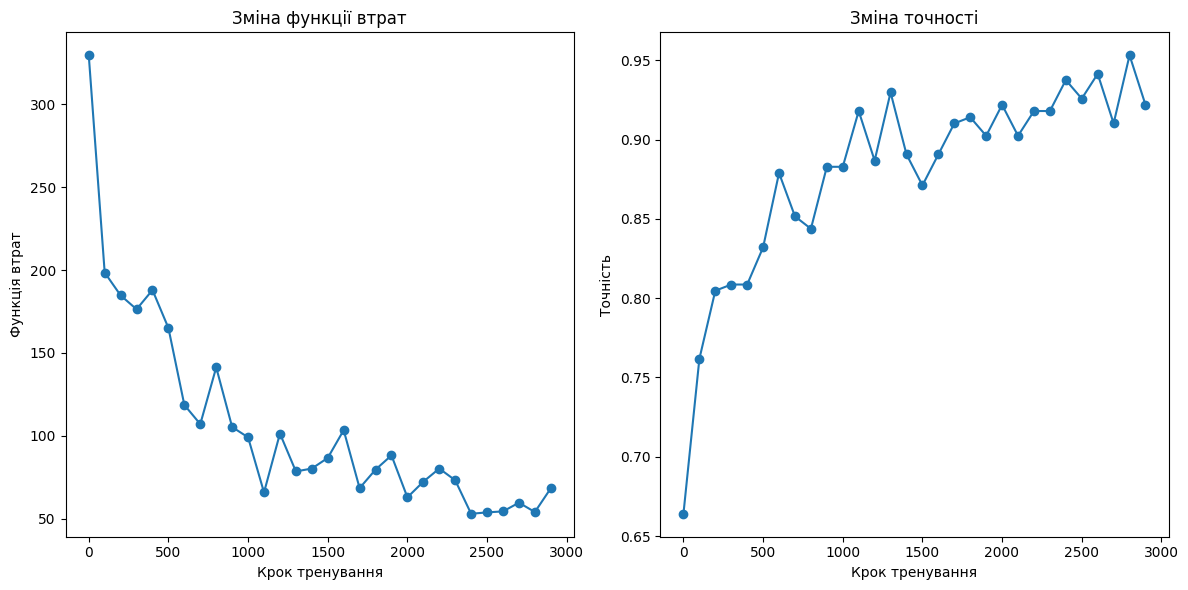

In [13]:
# Виведи графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведення графіка функції втрат
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, training_steps + 1, display_step), loss_history, marker='o', linestyle='-')
plt.title('Зміна функції втрат')
plt.xlabel('Крок тренування')
plt.ylabel('Функція втрат')

# Виведення графіка точності
plt.subplot(1, 2, 2)
plt.plot(range(1, training_steps + 1, display_step), accuracy_history, marker='o', linestyle='-')
plt.title('Зміна точності')
plt.xlabel('Крок тренування')
plt.ylabel('Точність')

plt.tight_layout()
plt.show()


In [10]:
# Обчисли точність навченої нейромережі

# Тестування моделі на тестових даних
test_pred = neural_net(x_test)
print(f"Точність на тестових даних: {accuracy(test_pred, y_test)*100:.2f}%")

Точність на тестових даних: 90.50%


2023-12-25 09:38:09.204493: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


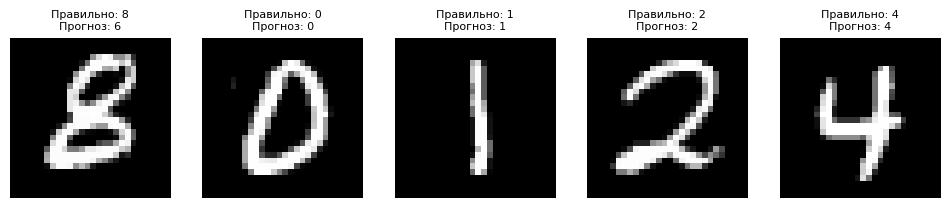

Точність на цих 5 зображеннях: 80.00%


In [29]:
# Протестуємо навчену нейромережу на 10 зображеннях. З тестової вибірки візьми 5
# випадкових зображень і передай їх у нейронну мережу.
# Виведи зображення та випиши поруч відповідь нейромережі.
# Зроби висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

import random

# Виберемо 5 випадкових зображень з тестової вибірки
random_indices = random.sample(range(len(x_test)), 10)
test_images = x_test[random_indices]
test_labels = y_test[random_indices]

predictions = neural_net(test_images)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(test_images[i].reshape((28, 28)), cmap='gray')
    plt.title(f"Правильно: {test_labels[i]}\nПрогноз: {predicted_labels[i]}", fontsize=8)
    plt.axis('off')

plt.show()

correct_predictions = (predicted_labels == test_labels)
accuracy = sum(correct_predictions) / len(correct_predictions)
print(f"Точність на цих 5 зображеннях: {accuracy * 100:.2f}%")



Є декілька можливих причин, чому точність моделі на тестових даних може бути меншою, ніж на тренувальних.

Перенавчання (Overfitting): Модель може бути налаштована занадто добре на тренувальних даних, але виявляється менш ефективною на нових, раніше не бачених даних. Це може бути внаслідок занадто складної архітектури мережі, яка вивчає шум чи деталі тренувальних даних, що не є репрезентативними для загального навчання.

Недостатність тренувальних даних: Можливо, набір тренувальних даних недостатній або не репрезентативний для реального розпізнавання рукописних цифр. Додавання більше різноманітних даних або збільшення обсягу тренувального набору може поліпшити результати.

Невірно налаштовані гіперпараметри: Швидкість навчання, кількість шарів та нейронів, функції активації та інші гіперпараметри можуть бути вибрані неоптимально. Важливо експериментувати з цими параметрами для знаходження оптимальних значень.

На основі результатів на тренувальних данних модель справилась непогано, так як точність за 3000 епох = 0,905, що є непоганим показником для моделі tensorflow 1.0. З тестовими данними модель справилась бездоганно так як було відгадано 90% тестових зображень

На основі результатів тренування та тестування можна робити висновки про якість навченої мережі, її ефективність у вирішенні завдання розпізнавання рукописних цифр та можливі шляхи подальшого вдосконалення.